In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
# read the data anchor points
df = pd.read_csv('points.csv', delimiter=';')
df.tail()

,fname,x0,y0,x1,y1,x2,y2
25,images/IMG_1011.jpeg,819,2095,3816,2340,2730,2702
26,images/IMG_1012.jpeg,741,2113,3726,2389,2652,2743
27,images/IMG_1013.jpeg,722,2159,3715,2389,2649,2762
28,images/IMG_1014.jpeg,713,2132,3698,2414,2628,2765
29,images/IMG_1015.jpeg,679,2162,3670,2433,2603,2791


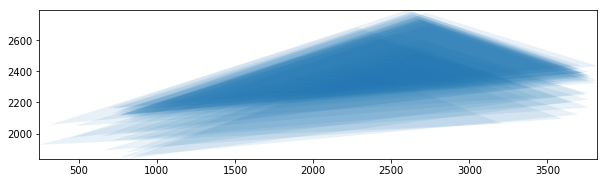

In [3]:
# show the raw anchor points

# variables to store mins/maxes
xmin = 9e9
ymin = 9e9

xmax = -9e9
ymax = -9e9

# loop through anchor points and construct patches
patches = []
for i, row in df.iterrows():
    xy = np.array([[row.x0, row.y0], [row.x1, row.y1], [row.x2, row.y2]])
    xmin_, ymin_ = xy.min(0)
    xmax_, ymax_ = xy.max(0)
    xmin = min(xmin, xmin_)
    ymin = min(ymin, ymin_)
    xmax = max(xmax, xmax_)
    ymax = max(ymax, ymax_)
    
    polygon = Polygon(xy, True)
    patches.append(polygon)
    
# plot the patch collection
p = PatchCollection(patches, alpha=0.1)
fig, ax = plt.subplots(figsize=(10, 10))
ax.add_collection(p)
ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
ax.set_aspect(1)
plt.show()

2985 440
2968 436
2973 438
2966 424
2958 435
2979 441
2972 442
2952 431
2965 438
2966 437
2946 429
2970 436
3004 448
3005 451
3006 453
3005 450
3002 448
3004 449
3000 449
3007 450
3016 451
3001 448
2997 449
3001 450
3009 454
3006 449
2997 451
3001 453
2998 450
3003 452


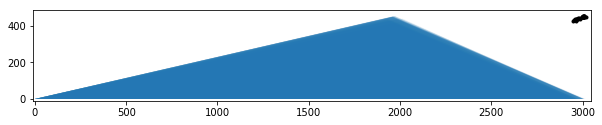

In [4]:
# translate and rotate triangle

# variables to store mins/maxes
xmin = 9e9
ymin = 9e9

xmax = -9e9
ymax = -9e9

# create list of patches
patches = []

# create figure
fig, ax = plt.subplots(figsize=(10, 10))

# loop through anchor points
for i, row in df.iterrows():
    # pin to bottom left corner
    xy = np.array([
        [0, 0], 
        [row.x1 - row.x0, row.y1 - row.y0], 
        [row.x2 - row.x0, row.y2 - row.y0]
    ])
    
    # compute rotation angle and apply rotation
    phi = np.arctan2(xy[1, 1], xy[1, 0])
    m = np.array([[np.cos(phi), -np.sin(phi)], [np.sin(phi), np.cos(phi)]])
    xy = (xy @ m)
    
    # plot max points
    xmin_, ymin_ = xy.min(0)
    xmax_, ymax_ = xy.max(0)
    assert int(xmin_) == int(ymin_) == 0
    print(int(xmax_), int(ymax_))
    ax.plot(xmax_, ymax_, 'k.')
    
    xmin = min(xmin, xmin_)
    ymin = min(ymin, ymin_)
    xmax = max(xmax, xmax_)
    ymax = max(ymax, ymax_)
    
    polygon = Polygon(xy, True)
    patches.append(polygon)

# display translated and rotated triangles
p = PatchCollection(patches, alpha=0.1, zorder=-1)
ax.add_collection(p)
ax.set_xlim((xmin-10, xmax+30))
ax.set_ylim((ymin-10, ymax+30))
ax.set_aspect(1)
plt.show()

In [5]:
# test rotation method on full images
files = sorted(glob.glob('images/*.jpeg'))

f0 = files[-15]
f1 = files[3]
print(f0, f1)

images/IMG_1001.jpeg images/IMG_0919.jpeg


In [6]:
p0 = df.query('fname == "%s"' % f0).iloc[0]
p1 = df.query('fname == "%s"' % f1).iloc[0]

In [7]:
# extract coordinates
xy = lambda p: np.array([
    [p['x0'], p['y0']],
    [p['x1'], p['y1']],
    [p['x2'], p['y2']],
])

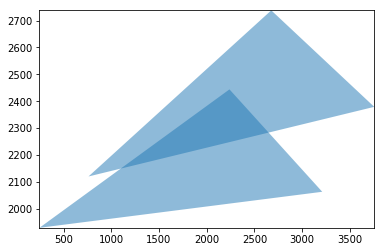

In [8]:
XY = np.r_[xy(p0), xy(p1)]
xmin, ymin = XY.min(0)
xmax, ymax = XY.max(0)

patches = PatchCollection([
    Polygon(xy(p0)), 
    Polygon(xy(p1))
], alpha=0.5)

fig, ax = plt.subplots()
ax.add_collection(patches)

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

In [9]:
xy(p1) - xy(p0)

array([[-514, -191],
       [-545, -316],
       [-438, -294]])

In [1]:
m0 = np.c_[xy(p0), [1, 1, 1]].T

m1 = np.c_[xy(p1), [1, 1, 1]].T

T = m0 @ np.linalg.inv(m1)

(T @ m1).astype('int'), m0

NameError: name 'np' is not defined

In [78]:
f0, f1

('images/IMG_1001.jpeg', 'images/IMG_0919.jpeg')

In [79]:
z0 = cv2.imread(f0)
z1 = cv2.imread(f1)

In [80]:
T[:2]

array([[ 1.02076717e+00, -2.27859089e-01,  9.48389925e+02],
       [ 4.01643647e-02,  1.04472379e+00,  9.47670541e+01]])

In [92]:
h, w, _ = z0.shape
zt = cv2.warpAffine(np.transpose(z0, (1, 0, 2)), T[:2].astype('float32'), (h, w))

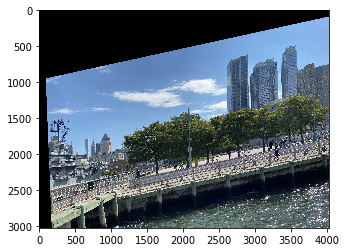

In [93]:
plt.imshow(np.transpose(zt[:, :, ::-1], (1, 0, 2)))

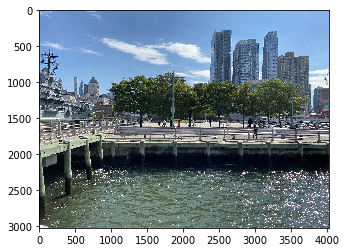

In [83]:
plt.imshow(z0[:, :, ::-1])